# Introduction to Jupyter Notebooks
## JupyterLab 🧪

**For an overview of the JupyterLab interface**, see the **JupyterLab Welcome Tour** on this page, by going to `Help -> Welcome Tour` and following the prompts.

> **See Also**: For a more in-depth tour of JupyterLab with a full environment that runs in the cloud, see [the JupyterLab introduction on Binder](https://mybinder.org/v2/gh/jupyterlab/jupyterlab-demo/HEAD?urlpath=lab/tree/demo).


# Sign Language Recognition Notebook
## Introduction

This notebook introduce sign language recognition. Original code can be found in the diverse folders of this repository.

<span style="color:red">**TO DO : add project description**</span>

### Environment
#### Installations

In [1]:
%pip install lsfb_dataset
%pip install numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


#### Importations

In [2]:
import pandas as pd
import os
from lsfb_dataset import Downloader
import cv2
from cv2 import VideoCapture
import mediapipe as mp
import joblib

## Data Manipulation
### Download dataset

Dataset is based on the LSFB Corpus. This corpus is the result of the tremendous work achieved by the members of the LSFB lab from the university of Namur. LSFB Dataset (lsfb_dataset) is a companion library for the French Belgian Sign Language (LSFB) dataset released by this university. The library provides a set of tools helping to download, manipulate and visualize the data. <br>

> **See More** : For a more in-depth tour of lsfb-dataset, see [lsfb-dataset documentation](https://lsfb-team.github.io/lsfb-dataset/).

**Please be aware that downloading data can take a while.** In order to limit the processing time or take less storage space, you can lower nb_signers.

In [3]:
nb_signers = 8

downloader = Downloader(
    dataset='isol',
    destination="../Database/Dataset",
    splits=['train','test'],
    signers=list(range(nb_signers)),
    include_cleaned_poses=True,
    include_raw_poses=False,
    include_videos=True,
    landmarks=['pose', 'left_hand', 'right_hand'],
    skip_existing_files=True,
)
downloader.download()

Metadata:   0%|          | 0/13 [00:00<?, ?files/s]

Poses for 19926 instances [pose, left_hand, right_hand]:   0%|          | 0/59778 [00:00<?, ?files/s]

Videos for 19926 instances:   0%|          | 0/19926 [00:00<?, ?files/s]

### Select data
The first selection of a video is based on the following criteria : 
 - it has more than 10 frames and less than 50 frames
 - it represents one of the 5 most represented signs of the global databaset
 - the word it represents is represented more than 50 times

> **Warning** : if necessary, please change the following directories to your dataset folder

In [4]:
videos_directory = "../Database/Dataset/videos/" 
df_instances = pd.read_csv('../Database/Dataset/instances.csv', engine='python')
df_index = pd.read_csv('../Database/sign_to_index.csv')

In [5]:
signs = [df_index.loc[i, "sign"] for i in range(5)]
points = [0,4,8,12,16,20]
print(signs)

['AUSSI', 'LS', 'OUI', 'AVOIR', 'SOURD']


How many values for each word ?

In [6]:
def Paths_Videos_Signing(word):
    """return a list of paths of videos signing the parameter word

    Args:
        word (string): word to search in dataset
    Returns:
        list: list of string representing video paths
    """
    videos = []
    df_instances_word = df_instances.loc[df_instances['sign'] == word]
    for title in df_instances_word['id']:
        path = videos_directory + title + ".mp4"
        if os.path.exists(path):
            videos.append(path)
    return videos

In [7]:
for sign in signs:
    print(f"{sign} : {len(Paths_Videos_Signing(sign))}")

AUSSI : 371
LS : 342
OUI : 314
AVOIR : 280
SOURD : 130


Selection based on numeric criteria

In [8]:
minimum_videos = 200 # Nombre minimal de vidéos pour pouvoir garder un mot en base de données
len_min = 10
len_max = 50

In [9]:
def Paths_Selected_Videos(word):
    videos = Paths_Videos_Signing(word)
    selected_videos = []
    for video in videos:
        cap = cv2.VideoCapture(video)
        length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if length>len_min and length<len_max:
            selected_videos.append(video)
    return selected_videos

In [10]:
for sign in signs:
    print(f"Number of videos signing '{sign}' : {len(Paths_Videos_Signing(sign))} before, {len(Paths_Selected_Videos(sign))} after")

Number of videos signing 'AUSSI' : 371 before, 297 after
Number of videos signing 'LS' : 342 before, 297 after
Number of videos signing 'OUI' : 314 before, 265 after
Number of videos signing 'AVOIR' : 280 before, 223 after
Number of videos signing 'SOURD' : 130 before, 109 after


In [11]:
for sign in signs:
    if len(Paths_Selected_Videos(sign))<minimum_videos:
        signs.remove(sign)

print("For the rest of the project, we will be working on the following words :")
print(signs)
joblib.dump(signs, "../DataManipulation/Data/Signs.pkl")

For the rest of the project, we will be working on the following words :
['AUSSI', 'LS', 'OUI', 'AVOIR']


['../DataManipulation/Data/Signs.pkl']

### Data formatting
#### Vectorization

<span style="color:red">**TO DO : add MediaPipe documentation**</span>

In [12]:
# Téléchargement du modèle détecteur de mains
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.8)

<span style="color:red">**TO DO : explain the first matrix**</span>
> **Warning**: We put 0 in lacking values because we want to distinguish them from NaN (auto-completion from pandas dataframes)

In [13]:
def Vectorize(video_path, points):
    """return a matrix containing the coordinates of points (according to MediaPipe) that have been extracted from the video saved in directory path

    Args:
        directory (string): path of the video that should be convert in matrix data
        points (list of int): list of index of MediaPipe points, please see documentation <https://developers.google.com/mediapipe/solutions/vision/hand_landmarker>
        
    Returns:
        nparray: matrix corresponding to the following data,
        [[XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P0
        [XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P4
        ...
        [XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P20
    """
    capture = VideoCapture(video_path)

    vect = [ [] for i in range(len(points))]
    while capture.isOpened():
        ret, frame = capture.read()
        if not ret:
            break 
        
        #BGR to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)# MediaPipe works with RGB format

        # Set flag
        image.flags.writeable = False

        #Detections
        results = hands.process(image)
        rang = 0
        for point in points:
            res = results.multi_hand_world_landmarks
            if res == None: # Without hand detection
                vect[rang].append("0")
                vect[rang].append("0")
                vect[rang].append("0")
                vect[rang].append("0")
                vect[rang].append("0")
                vect[rang].append("0")
            else :
                if len(res)>=2: # With a detection of both hands
                    hand = results.multi_hand_world_landmarks[0]
                    vect[rang].append(hand.landmark[point].x)
                    vect[rang].append(hand.landmark[point].y)
                    vect[rang].append(hand.landmark[point].z)
                    hand = results.multi_hand_world_landmarks[1]
                    vect[rang].append(hand.landmark[point].x)
                    vect[rang].append(hand.landmark[point].y)
                    vect[rang].append(hand.landmark[point].z)          
                
                elif len(res)==1: # With a one-hand detection
                    res2 = results.multi_handedness[0]
                    label = res2.classification[0].label
                    hand = results.multi_hand_world_landmarks[0]
                    if label == "Left":
                        vect[rang].append(hand.landmark[point].x)
                        vect[rang].append(hand.landmark[point].y)
                        vect[rang].append(hand.landmark[point].z)
                        vect[rang].append("0")
                        vect[rang].append("0")
                        vect[rang].append("0")
                        
                    elif label == "Right" :
                        vect[rang].append("0")
                        vect[rang].append("0")
                        vect[rang].append("0")
                        vect[rang].append(hand.landmark[point].x)
                        vect[rang].append(hand.landmark[point].y)
                        vect[rang].append(hand.landmark[point].z)
                
            rang +=1
        
    return vect

Conversion to dataframe format

In [14]:
def Create_DataFrame(video, points):
    """Create a dataframe based on what Vectorise function returns

    Args:
        video (string): path of the video that will be convert in a dataframe
        points (list of int): list of index of MediaPipe points, please see documentation <https://developers.google.com/mediapipe/solutions/vision/hand_landmarker>

    Returns:
        dataFrame: dataframe corresponding to the matrix extracted from the video given by Vectorise function
    """
    vect = Vectorize(video, points)
    col = ["Points"]
    
    for i in range(len(vect[0])//6):
        col += [f'xG{i}',f'yG{i}',f'zG{i}',f'xD{i}',f'yD{i}',f'zD{i}']
    
    df = pd.DataFrame(None, columns = col)
    for i in range(len(points)):
        df.loc[len(df.index)] = [f"P{4*i}"] + vect[i]

    return df

Example of the dataframe created from the first video signing "LS" in database

In [15]:
video = Paths_Selected_Videos("LS")[0]
Create_DataFrame(video, points)

,Points,xG0,yG0,zG0,xD0,yD0,zD0,xG1,yG1,zG1,...,zG15,xD15,yD15,zD15,xG16,yG16,zG16,xD16,yD16,zD16
0,P0,-0.035230,0.042146,0.073656,0.066154,0.008858,0.059337,-0.025272,0.046615,0.075060,...,0.075538,0.043564,0.014199,0.079540,0.029654,0.055051,0.074103,0.062954,0.018715,0.057508
1,P4,0.006634,-0.054196,0.005010,-0.001107,-0.074753,-0.000785,0.019382,-0.050444,0.009267,...,-0.000306,-0.025795,-0.061216,0.017933,0.062072,-0.047171,-0.012701,-0.015709,-0.005951,0.025426
2,P8,0.034817,0.017221,0.041634,-0.061179,-0.030260,0.020100,0.055951,0.004189,0.023389,...,-0.042504,-0.027040,-0.051357,-0.033080,-0.019221,-0.061134,-0.048849,-0.035414,-0.060699,-0.012632
3,P12,0.029182,0.012646,0.035624,-0.076076,0.001638,0.029415,0.047710,0.012097,0.028550,...,-0.071690,-0.048773,-0.010769,-0.022032,-0.043118,-0.027342,-0.067052,-0.057198,-0.011822,0.005704
4,P16,0.025709,0.027869,0.028479,-0.060427,0.019197,0.024898,0.044877,0.027482,0.027394,...,-0.057073,-0.057068,0.029403,-0.007605,-0.008420,0.039443,-0.038408,-0.059866,0.037741,0.020737
5,P20,0.033297,0.035249,0.004762,-0.041467,0.057452,0.017356,0.041275,0.039010,0.013481,...,-0.034258,-0.040132,0.061078,0.000094,-0.006039,0.052325,-0.017872,-0.038108,0.067305,0.020124


#### Generalisation
<span style="color:red">**TO DO : correct code about minimum number of videos**</span>

- concat info of every video
- save every video under a unique csv relative to the signed word

In [16]:
def Concatenate_DataFrame(sign, points):
    """concatenate data in a unique dataframe 

    Args:
        sign (list of stirng): list of sign that should be convert in numeric information
        points (list of int): list of index of MediaPipe points, please see documentation <https://developers.google.com/mediapipe/solutions/vision/hand_landmarker>
        
    Returns:
        pd.Dataframe: 
        [[XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P0
        [XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P4             --> video 1
        ...
        [XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P20
        
        ...
        
        [XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P0
        [XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P4             --> video N
        ...
        [XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P20]
    """
    videos = Paths_Selected_Videos(sign)
    df = pd.DataFrame(None)

    if len(videos)>=minimum_videos:
        for video in videos:
            df = pd.concat([df,Create_DataFrame(video, points)], ignore_index=True)
    return df

<span style="color:red">**TO DO : add a part for use df without save them under csv ?**</span>

Example for the word "LS"

In [20]:
#Concatenate_DataFrame("LS", points)

KeyboardInterrupt: 

In [17]:
def SaveInCSV(sign, points):
    """save dataframe created by Concatenate_DataFrame in csv

    Args:
        sign (string): sign that should be convert in numeric information
        points (list of int): list of index of MediaPipe points, please see documentation <https://developers.google.com/mediapipe/solutions/vision/hand_landmarker>
        
    """
    if not os.path.exists(f'../Database/Positions/{sign}.csv'):
        df = Concatenate_DataFrame(sign, points)
        df.to_csv(f'../Database/Positions/{sign}.csv', index=False)

In [22]:
# Do not execute ~ 17 min
for sign in signs:
    SaveInCSV(sign,points)

KeyboardInterrupt: 

### Data processing

Concatenate every sign data before in order to have same length for every X vector

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [19]:
signs = joblib.load("../DataManipulation/Data/Signs.pkl")
signs

['AUSSI', 'LS', 'OUI', 'AVOIR']

In [ ]:
List_df_signs = [pd.read_csv(f"../Database/Positions/{sign}.csv") for sign in signs]
df_All = pd.concat(List_df_signs)
df_All

FileNotFoundError: [Errno 2] No such file or directory: '../Database/Positions/AUSSI.csv'

- Convert to numpy to concatenate rows

In [ ]:
All = np.array(df_All)
final_vector = []
for i in range (len(All)//len(points)):
    final_vector += [np.concatenate([All[point+i*6][1:] for point in range(6)])]

- Return to Dataframe

In [ ]:
df_All = pd.DataFrame(final_vector)
df_All

,0,1,2,3,4,5,6,7,8,9,...,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015559,0.083049,0.044787,0.006316,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012938,0.082440,0.041306,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060475,0.006571,0.077605,0.012307,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.049384,0.030766,0.071968,-0.016525,0.074820,0.068859,0.049453,0.028812,0.075394,-0.008487,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.049849,0.021614,0.077442,-0.022396,0.072228,0.072210,0.046102,0.027305,0.079739,-0.012087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001044,0.041654,0.090977,-0.041178,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1078,-0.063210,0.061234,0.047186,0.000000,0.000000,0.000000,0.043812,-0.036999,0.073891,-0.058167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1079,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1080,0.009083,0.077887,0.048610,-0.004348,0.083721,0.034025,0.009551,0.076776,0.058762,-0.008330,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Find targets

In [ ]:
df_correspondances = pd.read_csv('../Database/sign_to_index.csv')
targets =[]
for num_sign in range(len(signs)):
    ind = 0
    nb_videos = List_df_signs[num_sign].shape[0]//len(points)
    while ind < df_correspondances.shape[0] and df_correspondances.loc[ind, "sign"]!=signs[num_sign]:
        ind+=1
    targets += [ind]*nb_videos
unique, counts = np.unique(targets, return_counts=True)
dict(zip(unique, counts))

NameError: name 'List_df_signs' is not defined

- Concatenate data (X and y)

In [ ]:
X = np.array(df_All)
X_training, X_test, y_training, y_test = train_test_split(X, targets, test_size=0.20)

df_training = pd.DataFrame(X_training)
df_training.insert(loc=0, column='Target', value=y_training)
df_test = pd.DataFrame(X_test)
df_test.insert(loc=0, column='Target', value=y_test)

df_training

,Target,0,1,2,3,4,5,6,7,8,...,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763
0,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.010482,0.015072,0.077826,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,-0.014672,0.084513,-0.028159,-0.015460,0.036203,0.071888,-0.013511,0.087423,-0.024408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0.000000,0.000000,0.000000,-0.011880,0.035833,0.082438,-0.005975,0.053875,0.075777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014841,0.084725,0.042627,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016561,0.088697,0.039008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.004989,-0.034713,0.073856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
915,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.034280,0.066748,-0.006117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
916,3,0.011161,0.002662,0.045094,-0.030442,0.050180,0.033386,0.022636,-0.003509,0.055929,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
917,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.042946,0.032435,0.076222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_training.to_csv(f'../DataManipulation/Data/RawTraining.csv', index=False)
df_test.to_csv(f'../DataManipulation/Data/RawTest.csv', index=False)

#### Data Preparation

In [ ]:
df_training = pd.read_csv("../DataManipulation/Data/RawTraining.csv")
df_test = pd.read_csv("../DataManipulation/Data/RawTest.csv")

On ne garde que les vidéos dont 99% des valeurs enregistrées (pour sa durée) portent de l'information

In [ ]:
def Keep_Indicatives(df_data):
    Data = np.array(df_data)
    ind_video = 0 
    for video in Data:
        number_of_zero = np.count_nonzero(video[1:] == 0)
        nbTotal = np.count_nonzero(video[1:] != np.nan)
        if number_of_zero>0.1*nbTotal:
            Data = np.delete(Data, ind_video, axis=0)
        else:
            ind_video +=1
    return Data

How many videos left ?

In [ ]:
df_data = pd.read_csv(f"../DataManipulation/Data/Training.csv")
print(f"Number of videos before 2nd selection on training set : {df_training.shape[0]}")
new = Keep_Indicatives(df_training)
print(f"Number of videos after 2nd selection on training set : {len(new)}")
unique, counts = np.unique(new[:,0], return_counts=True)
dict(zip(unique, counts))

Number of videos before 2nd selection on training set : 919
Number of videos after 2nd selection on training set : 604


{0.0: 184, 1.0: 128, 2.0: 141, 3.0: 151}

In [ ]:
df_training = pd.DataFrame(Keep_Indicatives(df_training))
df_test = pd.DataFrame(Keep_Indicatives(df_test))
df_training

,0,1,2,3,4,5,6,7,8,9,...,1755,1756,1757,1758,1759,1760,1761,1762,1763,1764
0,2.0,-0.014672,0.084513,-0.028159,-0.015460,0.036203,0.071888,-0.013511,0.087423,-0.024408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.000000,0.000000,0.000000,-0.011880,0.035833,0.082438,-0.005975,0.053875,0.075777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014841,0.084725,0.042627,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016561,0.088697,0.039008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.005566,0.020592,0.084844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,1.0,-0.046215,0.030234,0.072677,0.000000,0.000000,0.000000,0.005872,0.006030,-0.009393,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016480,0.058491,0.065937,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
601,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060749,0.015240,0.063356,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
602,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.034280,0.066748,-0.006117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Transformer les NaN en 0

In [ ]:
Data_training = SimpleImputer(strategy="constant", missing_values=np.nan, fill_value=0).fit_transform(df_training)
Data_test = SimpleImputer(strategy="constant", missing_values=np.nan, fill_value=0).fit_transform(df_test)

In [ ]:
X_training = [Data_training[video][1:] for video in range(len(Data_training))]
y_training = [Data_training[video][0] for video in range(len(Data_training))]
X_test = [Data_test[video][1:] for video in range(len(Data_test))]
y_test = [Data_test[video][0] for video in range(len(Data_test))]

In [ ]:
df_training = pd.DataFrame(X_training)
df_training.insert(loc=0, column='Target', value=y_training)
df_test = pd.DataFrame(X_test)
df_test.insert(loc=0, column='Target', value=y_test)
df_training

,Target,0,1,2,3,4,5,6,7,8,...,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763
0,2.0,-0.014672,0.084513,-0.028159,-0.015460,0.036203,0.071888,-0.013511,0.087423,-0.024408,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.000000,-0.011880,0.035833,0.082438,-0.005975,0.053875,0.075777,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014841,0.084725,0.042627,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016561,0.088697,0.039008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.005566,0.020592,0.084844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,1.0,-0.046215,0.030234,0.072677,0.000000,0.000000,0.000000,0.005872,0.006030,-0.009393,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
600,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016480,0.058491,0.065937,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
601,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060749,0.015240,0.063356,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
602,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.034280,0.066748,-0.006117,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


For the rest of the Notebook, we will use Test.csv and Training.csv files as datasets.

In [ ]:
df_training.to_csv(f'../DataManipulation/Data/Training.csv', index=False)
df_test.to_csv(f'../DataManipulation/Data/Test.csv', index=False)

## Models
### Support vector machines
#### Importation

In [23]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [28]:
data_training = pd.read_csv("../DataManipulation/Data/Training.csv")
data_test = pd.read_csv("../DataManipulation/Data/Test.csv")
data_training

,Target,0,1,2,3,4,5,6,7,8,...,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763
0,2.0,-0.014672,0.084513,-0.028159,-0.015460,0.036203,0.071888,-0.013511,0.087423,-0.024408,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.000000,-0.011880,0.035833,0.082438,-0.005975,0.053875,0.075777,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014841,0.084725,0.042627,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016561,0.088697,0.039008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.005566,0.020592,0.084844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,1.0,-0.046215,0.030234,0.072677,0.000000,0.000000,0.000000,0.005872,0.006030,-0.009393,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
600,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016480,0.058491,0.065937,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
601,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060749,0.015240,0.063356,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
602,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.034280,0.066748,-0.006117,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
X_training = data_training.iloc[ : , 1:]
y_training = data_training['Target']
X_test = data_test.iloc[ : , 1:]
y_test = data_test['Target']

X_training

,0,1,2,3,4,5,6,7,8,9,...,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763
0,-0.014672,0.084513,-0.028159,-0.015460,0.036203,0.071888,-0.013511,0.087423,-0.024408,-0.021944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,-0.011880,0.035833,0.082438,-0.005975,0.053875,0.075777,-0.010324,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014841,0.084725,0.042627,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016561,0.088697,0.039008,-0.014061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.005566,0.020592,0.084844,0.012456,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,-0.046215,0.030234,0.072677,0.000000,0.000000,0.000000,0.005872,0.006030,-0.009393,-0.044739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016480,0.058491,0.065937,-0.012464,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
601,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060749,0.015240,0.063356,-0.024599,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
602,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.034280,0.066748,-0.006117,0.037647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Training

In [56]:
SVM_model = svm.SVC(probability=True)
SVM_model.fit(X_training, y_training)

SVC(probability=True)

#### Results

Accuracy

In [57]:
y_pred = SVM_model.predict(X_test)
train_acc = SVM_model.score(X_training, y_training)
print(f"Training accuracy: {train_acc:.05f}")
test_acc = np.sum(y_pred == y_test) / len(y_test)
print(f"Test accuracy: {test_acc:.3f}")

Training accuracy: 0.94205
Test accuracy: 0.830


In [58]:
print(classification_report(y_training, SVM_model.predict(X_training)))
print(classification_report(y_test, SVM_model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       184
         1.0       0.95      0.94      0.94       128
         2.0       0.98      0.93      0.95       141
         3.0       0.90      0.93      0.91       151

    accuracy                           0.94       604
   macro avg       0.94      0.94      0.94       604
weighted avg       0.94      0.94      0.94       604

              precision    recall  f1-score   support

         0.0       0.85      0.97      0.91        30
         1.0       0.80      0.80      0.80        20
         2.0       0.84      0.73      0.78        22
         3.0       0.81      0.77      0.79        22

    accuracy                           0.83        94
   macro avg       0.83      0.82      0.82        94
weighted avg       0.83      0.83      0.83        94



Cross-validation

In [59]:
cv_acc_training = cross_val_score(SVM_model, X_training, y_training, cv=5, scoring="accuracy")
cv_acc_test = cross_val_score(SVM_model, X_test, y_test, cv=5, scoring="accuracy")
print(f"Cross-validation training accuracy: {cv_acc_training}")
print(f"Cross-validation test accuracy: {cv_acc_test}")

Cross-validation training accuracy: [0.7768595  0.80991736 0.80991736 0.78512397 0.76666667]
Cross-validation test accuracy: [0.73684211 0.63157895 0.73684211 0.68421053 0.77777778]


Confusion matrix

Confusion matrix, without normalization
[[29  0  1  0]
 [ 2 16  1  1]
 [ 1  2 16  3]
 [ 2  2  1 17]]
Normalized confusion matrix
[[0.96666667 0.         0.03333333 0.        ]
 [0.1        0.8        0.05       0.05      ]
 [0.04545455 0.09090909 0.72727273 0.13636364]
 [0.09090909 0.09090909 0.04545455 0.77272727]]


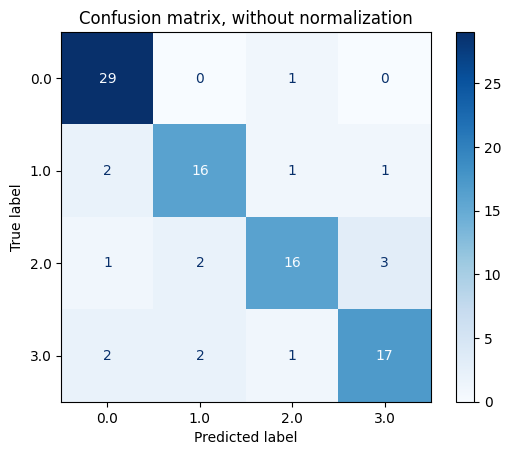

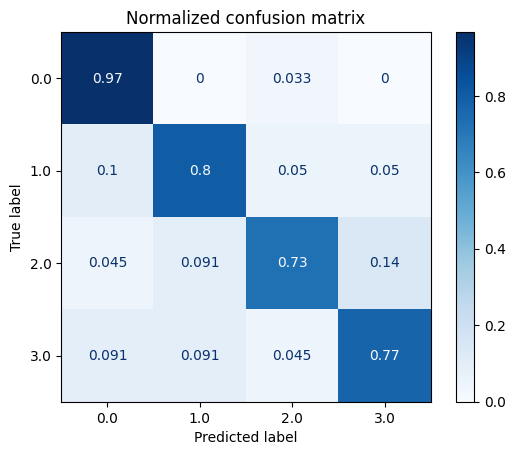

In [60]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        SVM_model,
        X_test,
        y_test,
        #display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()